<a href="https://colab.research.google.com/github/ziatdinovmax/SPM_ML_School_2021/blob/main/Day04/Notebooks/dkl_plasmons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DKL-GPR for active learning
This notebook demonstrates how to use a deep kernel learning (DKL)-based Gaussian process regression (GPR) for data reconstruction and automated experiments. We will be using the pre-acquired experimental dataset on plasmonic nanoparticles (HAADF + EELS) from Kevin Roccapriore.

*Prepared by Maxim Ziatdinov (August 2021)*

Intallations:

In [1]:
!pip install -q torch==1.8.1 torchvision==0.9.1 torchtext==0.9.1
!pip install -q atomai

     |████████████████████████████████| 804.1 MB 2.7 kB/s 
     |████████████████████████████████| 17.4 MB 223 kB/s 
     |████████████████████████████████| 7.1 MB 56.7 MB/s 
     |████████████████████████████████| 146 kB 7.5 MB/s 
     |████████████████████████████████| 193 kB 51.6 MB/s 
     |████████████████████████████████| 503 kB 49.8 MB/s 
     |████████████████████████████████| 865 kB 35.1 MB/s 


Imports:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split

import atomai as aoi

Download training data:

In [3]:
!wget -qq https://www.dropbox.com/s/1tguc2zraiyxg7h/Plasmonic_EELS_FITO0_edgehole_01.npy

Load data into the notebook:

In [4]:
loadedfile = np.load("Plasmonic_EELS_FITO0_edgehole_01.npy", allow_pickle=True).tolist()
for key, value in loadedfile.items():
  print(key, value.shape)

image (62, 75)
spectrum image (62, 75, 1496)
energy axis (1496,)
scale ()


In [5]:
img = loadedfile['image']
specim = loadedfile['spectrum image']
e_ax = loadedfile['energy axis']
imscale = loadedfile['scale']

Generate training inputs (image patches) and targets (spectra).

In [6]:
window_size = 12

coordinates = aoi.utils.get_coord_grid(img, step=1, return_dict=False)
features, targets, indices = aoi.utils.extract_patches_and_spectra(
    specim, img, coordinates=coordinates, window_size=window_size, avg_pool=16)

features.shape, targets.shape

((3264, 12, 12), (3264, 93))

Normalize data:

In [7]:
norm_ = lambda x: (x - x.min()) / x.ptp()
features, targets = norm_(features), norm_(targets)

Let's scalarize our vactor-valued targets. Here we are going to do the scalarization by simply using the intensity of largest plasmonic peak but more sophisticated scalar descritpors can be derived as well (ratio of peaks, etc.). First do it for a single spectrum:

25 0.7151328805097958


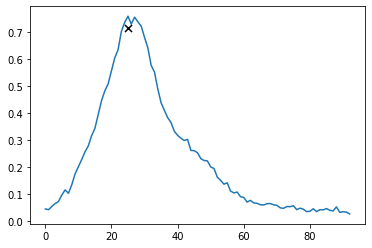

In [8]:
k = 1
peak_data = find_peaks(targets[k], width=5)
peak_pos, peak_int = peak_data[0][0], peak_data[1]['prominences'][0]
plt.plot(targets[k], zorder=0)
print(peak_pos, peak_int)
plt.scatter(peak_pos, peak_int, marker='x', s=50, c='k', zorder=1)

Same but for all the data:

In [9]:
peaks_all, features_all, indices_all = [], [], []
for i, t in enumerate(targets):
    peak = find_peaks(t, width=5)[1]["prominences"]
    if len(peak) == 0:
        continue
    peaks_all.append(np.array([peak[0]]) if len(peak) > 1 else peak)
    features_all.append(features[i])
    indices_all.append(indices[i])
peaks_all = np.concatenate(peaks_all)
features_all = np.array(features_all)
indices_all = np.array(indices_all)

Plot the scalarized target values for each feature coordinate:

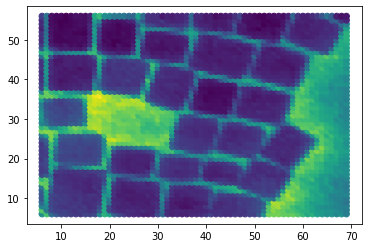

In [10]:
plt.scatter(indices_all[:, 1], indices_all[:, 0], c=peaks_all)

## DKL on full data

Prepare data for training:

In [11]:
n, d1, d2 = features_all.shape
X = features_all.reshape(n, d1*d2)
y = peaks_all
X.shape, y.shape

((3264, 144), (3264,))

Train:

In [12]:
data_dim = X.shape[-1]

dklgp = aoi.models.dklGPR(data_dim, embedim=2, precision="single")
dklgp.fit(X, y, training_cycles=100)

Epoch 1/100 ... Training loss: 0.7581
Epoch 10/100 ... Training loss: 0.7123
Epoch 20/100 ... Training loss: 0.6735
Epoch 30/100 ... Training loss: 0.6348
Epoch 40/100 ... Training loss: 0.5954
Epoch 50/100 ... Training loss: 0.5549
Epoch 60/100 ... Training loss: 0.5134
Epoch 70/100 ... Training loss: 0.471
Epoch 80/100 ... Training loss: 0.4272
Epoch 90/100 ... Training loss: 0.3844
Epoch 100/100 ... Training loss: 0.3384


Make a "prediction" on the training data (since we used all the data for training, our training and test datasets are the same, that is, we basically look at how well our model was able to "fit" the data):

In [13]:
mean, var = dklgp.predict(X, batch_size=len(X))

Text(0.5, 1.0, 'DKL uncertainty')

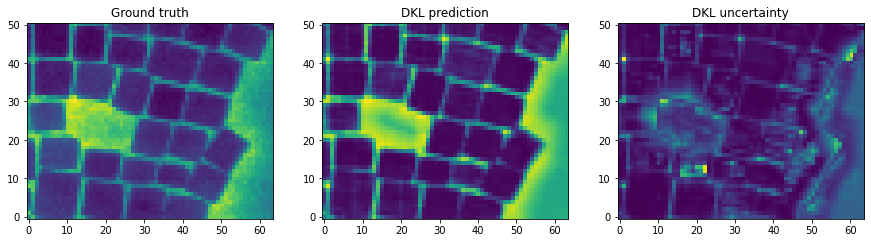

In [14]:
s1, s2 = img.shape[0] - window_size+1, img.shape[1] - window_size+1

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4.5))
ax1.imshow(peaks_all.reshape(s1, s2), origin="lower")
ax1.set_title("Ground truth")
ax2.imshow(mean.reshape(s1, s2))
ax2.set_title("DKL prediction")
ax2.imshow(mean.reshape(s1, s2), origin="lower")
ax3.imshow(var.reshape(s1, s2), origin="lower")
ax3.set_title("DKL uncertainty")

We can also visualize our latent/embedding space:

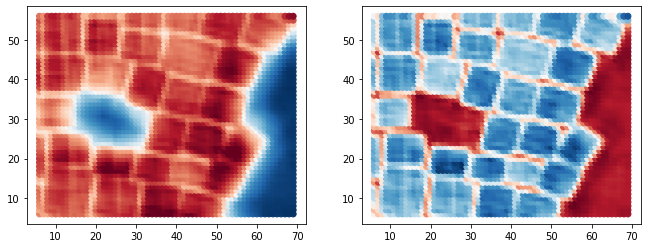

In [15]:
embeded = dklgp.embed(X)
embeded = embeded / embeded.max()

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
ax1.scatter(indices_all[:, 1], indices_all[:, 0], c=embeded[:, 0], cmap='RdBu')
ax2.scatter(indices_all[:, 1], indices_all[:, 0], c=embeded[:, 1], cmap='RdBu')

## DKL on partial data

Now let's use only a part of the data for training:

In [16]:
split_ = 30
X_train = X[indices_all[:, 1] < split_]
y_train = y[indices_all[:, 1] < split_]
indices_train = indices_all[indices_all[:, 1] < split_]

In [17]:
dklgp1 = aoi.models.dklGPR(data_dim, embedim=2, precision="single")
dklgp1.fit(X_train, y_train, training_cycles=100)

Epoch 1/100 ... Training loss: 0.768
Epoch 10/100 ... Training loss: 0.7272
Epoch 20/100 ... Training loss: 0.6866
Epoch 30/100 ... Training loss: 0.6481
Epoch 40/100 ... Training loss: 0.6064
Epoch 50/100 ... Training loss: 0.5645
Epoch 60/100 ... Training loss: 0.5183
Epoch 70/100 ... Training loss: 0.4775
Epoch 80/100 ... Training loss: 0.4319
Epoch 90/100 ... Training loss: 0.3884
Epoch 100/100 ... Training loss: 0.3418


Make a prediction on all the data:

In [18]:
mean, var = dklgp1.predict(X, batch_size=len(X))

Plot the prediction. The dotted vertical line divides the part used for training (left hand side) from the testing (right hand side) part.

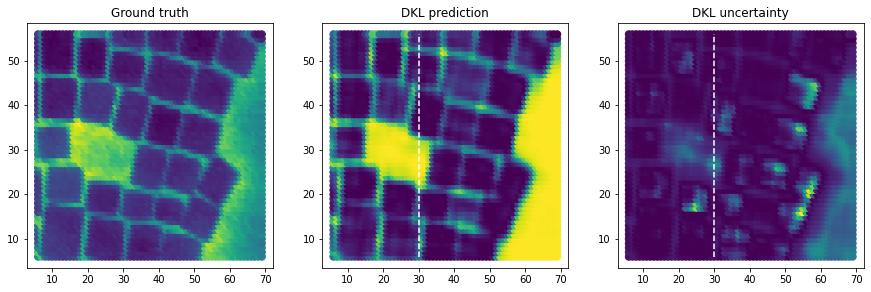

In [19]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4.5))
ax1.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=peaks_all)
ax1.set_title("Ground truth")
ax2.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=mean)
ax2.set_title("DKL prediction")
ax3.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=var)
ax3.set_title("DKL uncertainty")
ax2.vlines(split_, indices_all[:, 0].min(), indices_all[:, 0].max(), linestyle='--', color='w')
ax3.vlines(split_, indices_all[:, 0].min(), indices_all[:, 0].max(), linestyle='--', color='w')

## Active learning

Here we are going to use DKL for active learning aimed at identifying regions of the sample where a particular behavior (plasmon resonance peak) is maximized. We start with just three "measured" points:

In [38]:
# Here X_train and y_train are our measured image patches (HAADF) and spectra/peaks (EELS),
# whereas X_test and y_test are the "unkwown" ones. The indices_train are grid coordinates of the measured points,
# whereas the indices_test are the grid coordinates of the remaining available points on the grid
(X_train, X_test, y_train, y_test,
  indices_train, indices_test) = train_test_split(
      X, y, indices_all, test_size=0.999, shuffle=True, random_state=4)

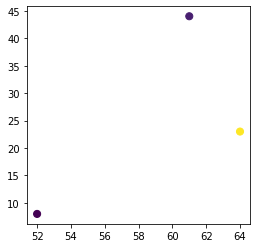

In [39]:
plt.figure(figsize=(4, 4))
plt.scatter(indices_train[:, 1], indices_train[:, 0], s=50, c=y_train)

Do sample exploration based on the pre-acquired data (i.e., we are running a "dummy" experiment):

1/40
Epoch 1/200 ... Training loss: 1.023
Epoch 10/200 ... Training loss: 0.9988
Epoch 20/200 ... Training loss: 0.9124
Epoch 30/200 ... Training loss: 0.8479
Epoch 40/200 ... Training loss: 0.7918
Epoch 50/200 ... Training loss: 0.737
Epoch 60/200 ... Training loss: 0.6844
Epoch 70/200 ... Training loss: 0.634
Epoch 80/200 ... Training loss: 0.5851
Epoch 90/200 ... Training loss: 0.5367
Epoch 100/200 ... Training loss: 0.4886
Epoch 110/200 ... Training loss: 0.4408
Epoch 120/200 ... Training loss: 0.3937
Epoch 130/200 ... Training loss: 0.3474
Epoch 140/200 ... Training loss: 0.302
Epoch 150/200 ... Training loss: 0.2577
Epoch 160/200 ... Training loss: 0.2147
Epoch 170/200 ... Training loss: 0.1732
Epoch 180/200 ... Training loss: 0.1333
Epoch 190/200 ... Training loss: 0.0951
Epoch 200/200 ... Training loss: 0.059


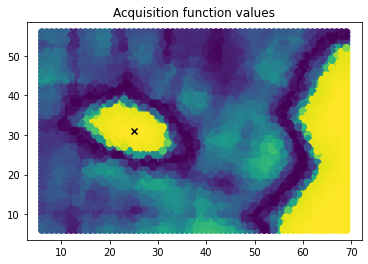

2/40
Epoch 1/200 ... Training loss: 1.0081
Epoch 10/200 ... Training loss: 0.9958
Epoch 20/200 ... Training loss: 0.9294
Epoch 30/200 ... Training loss: 0.8573
Epoch 40/200 ... Training loss: 0.7923
Epoch 50/200 ... Training loss: 0.7302
Epoch 60/200 ... Training loss: 0.6742
Epoch 70/200 ... Training loss: 0.6248
Epoch 80/200 ... Training loss: 0.5768
Epoch 90/200 ... Training loss: 0.5299
Epoch 100/200 ... Training loss: 0.4834
Epoch 110/200 ... Training loss: 0.4373
Epoch 120/200 ... Training loss: 0.3917
Epoch 130/200 ... Training loss: 0.347
Epoch 140/200 ... Training loss: 0.303
Epoch 150/200 ... Training loss: 0.2583
Epoch 160/200 ... Training loss: 0.2053
Epoch 170/200 ... Training loss: 0.1573
Epoch 180/200 ... Training loss: 0.1105
Epoch 190/200 ... Training loss: 0.0684
Epoch 200/200 ... Training loss: 0.0286


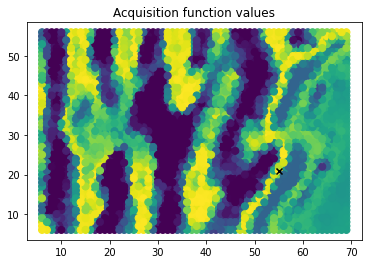

3/40
Epoch 1/200 ... Training loss: 0.978
Epoch 10/200 ... Training loss: 0.9596
Epoch 20/200 ... Training loss: 0.8946
Epoch 30/200 ... Training loss: 0.8402
Epoch 40/200 ... Training loss: 0.7887
Epoch 50/200 ... Training loss: 0.7388
Epoch 60/200 ... Training loss: 0.6903
Epoch 70/200 ... Training loss: 0.6434
Epoch 80/200 ... Training loss: 0.597
Epoch 90/200 ... Training loss: 0.5499
Epoch 100/200 ... Training loss: 0.5046
Epoch 110/200 ... Training loss: 0.4599
Epoch 120/200 ... Training loss: 0.416
Epoch 130/200 ... Training loss: 0.3742
Epoch 140/200 ... Training loss: 0.3301
Epoch 150/200 ... Training loss: 0.2878
Epoch 160/200 ... Training loss: 0.245
Epoch 170/200 ... Training loss: 0.2033
Epoch 180/200 ... Training loss: 0.1645
Epoch 190/200 ... Training loss: 0.1283
Epoch 200/200 ... Training loss: 0.0946


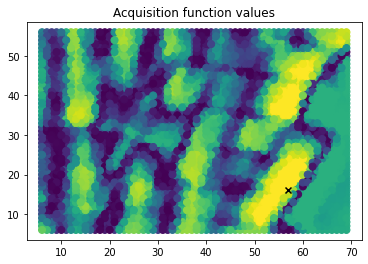

4/40
Epoch 1/200 ... Training loss: 0.9519
Epoch 10/200 ... Training loss: 0.9325
Epoch 20/200 ... Training loss: 0.8746
Epoch 30/200 ... Training loss: 0.8241
Epoch 40/200 ... Training loss: 0.7746
Epoch 50/200 ... Training loss: 0.7261
Epoch 60/200 ... Training loss: 0.6784
Epoch 70/200 ... Training loss: 0.6317
Epoch 80/200 ... Training loss: 0.5871
Epoch 90/200 ... Training loss: 0.5426
Epoch 100/200 ... Training loss: 0.4979
Epoch 110/200 ... Training loss: 0.4531
Epoch 120/200 ... Training loss: 0.4084
Epoch 130/200 ... Training loss: 0.364
Epoch 140/200 ... Training loss: 0.3202
Epoch 150/200 ... Training loss: 0.2778
Epoch 160/200 ... Training loss: 0.2367
Epoch 170/200 ... Training loss: 0.1958
Epoch 180/200 ... Training loss: 0.1567
Epoch 190/200 ... Training loss: 0.1196
Epoch 200/200 ... Training loss: 0.085


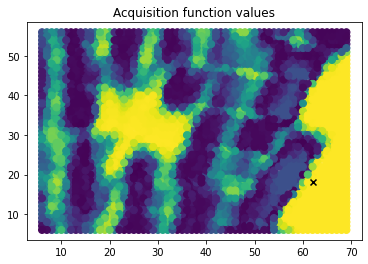

5/40
Epoch 1/200 ... Training loss: 0.9438
Epoch 10/200 ... Training loss: 0.9187
Epoch 20/200 ... Training loss: 0.8654
Epoch 30/200 ... Training loss: 0.8151
Epoch 40/200 ... Training loss: 0.7655
Epoch 50/200 ... Training loss: 0.7185
Epoch 60/200 ... Training loss: 0.6728
Epoch 70/200 ... Training loss: 0.6274
Epoch 80/200 ... Training loss: 0.5818
Epoch 90/200 ... Training loss: 0.5358
Epoch 100/200 ... Training loss: 0.4896
Epoch 110/200 ... Training loss: 0.4446
Epoch 120/200 ... Training loss: 0.3997
Epoch 130/200 ... Training loss: 0.3555
Epoch 140/200 ... Training loss: 0.3121
Epoch 150/200 ... Training loss: 0.2706
Epoch 160/200 ... Training loss: 0.2278
Epoch 170/200 ... Training loss: 0.1858
Epoch 180/200 ... Training loss: 0.1452
Epoch 190/200 ... Training loss: 0.1063
Epoch 200/200 ... Training loss: 0.0692


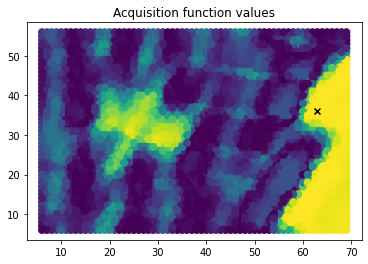

6/40
Epoch 1/200 ... Training loss: 0.9281
Epoch 10/200 ... Training loss: 0.9037
Epoch 20/200 ... Training loss: 0.8504
Epoch 30/200 ... Training loss: 0.8
Epoch 40/200 ... Training loss: 0.7527
Epoch 50/200 ... Training loss: 0.7069
Epoch 60/200 ... Training loss: 0.6617
Epoch 70/200 ... Training loss: 0.6176
Epoch 80/200 ... Training loss: 0.5719
Epoch 90/200 ... Training loss: 0.5253
Epoch 100/200 ... Training loss: 0.4782
Epoch 110/200 ... Training loss: 0.4315
Epoch 120/200 ... Training loss: 0.3855
Epoch 130/200 ... Training loss: 0.3369
Epoch 140/200 ... Training loss: 0.2908
Epoch 150/200 ... Training loss: 0.2462
Epoch 160/200 ... Training loss: 0.2029
Epoch 170/200 ... Training loss: 0.1612
Epoch 180/200 ... Training loss: 0.121
Epoch 190/200 ... Training loss: 0.0824
Epoch 200/200 ... Training loss: 0.0453


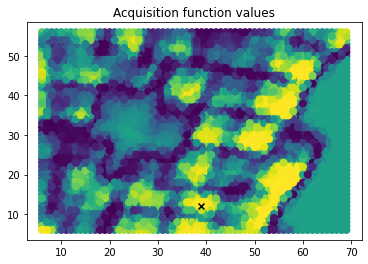

7/40
Epoch 1/200 ... Training loss: 0.9167
Epoch 10/200 ... Training loss: 0.8931
Epoch 20/200 ... Training loss: 0.8465
Epoch 30/200 ... Training loss: 0.794
Epoch 40/200 ... Training loss: 0.745
Epoch 50/200 ... Training loss: 0.7008
Epoch 60/200 ... Training loss: 0.6561
Epoch 70/200 ... Training loss: 0.6119
Epoch 80/200 ... Training loss: 0.5674
Epoch 90/200 ... Training loss: 0.5225
Epoch 100/200 ... Training loss: 0.4776
Epoch 110/200 ... Training loss: 0.4324
Epoch 120/200 ... Training loss: 0.387
Epoch 130/200 ... Training loss: 0.3418
Epoch 140/200 ... Training loss: 0.2973
Epoch 150/200 ... Training loss: 0.2533
Epoch 160/200 ... Training loss: 0.2101
Epoch 170/200 ... Training loss: 0.1679
Epoch 180/200 ... Training loss: 0.1271
Epoch 190/200 ... Training loss: 0.0881
Epoch 200/200 ... Training loss: 0.0505


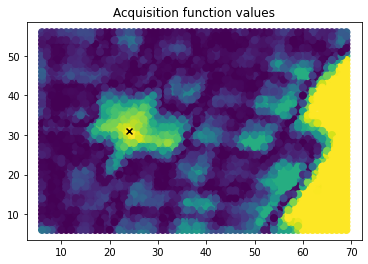

8/40
Epoch 1/200 ... Training loss: 0.9113
Epoch 10/200 ... Training loss: 0.8882
Epoch 20/200 ... Training loss: 0.8402
Epoch 30/200 ... Training loss: 0.7892
Epoch 40/200 ... Training loss: 0.7453
Epoch 50/200 ... Training loss: 0.6944
Epoch 60/200 ... Training loss: 0.6496
Epoch 70/200 ... Training loss: 0.6057
Epoch 80/200 ... Training loss: 0.5619
Epoch 90/200 ... Training loss: 0.5178
Epoch 100/200 ... Training loss: 0.4735
Epoch 110/200 ... Training loss: 0.4288
Epoch 120/200 ... Training loss: 0.3838
Epoch 130/200 ... Training loss: 0.3395
Epoch 140/200 ... Training loss: 0.2953
Epoch 150/200 ... Training loss: 0.2519
Epoch 160/200 ... Training loss: 0.2093
Epoch 170/200 ... Training loss: 0.1677
Epoch 180/200 ... Training loss: 0.126
Epoch 190/200 ... Training loss: 0.0845
Epoch 200/200 ... Training loss: 0.0445


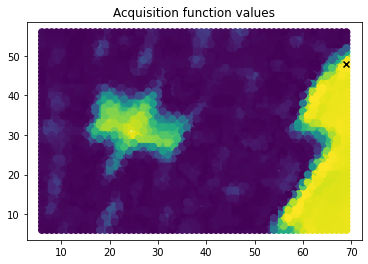

9/40
Epoch 1/200 ... Training loss: 0.9008
Epoch 10/200 ... Training loss: 0.8802
Epoch 20/200 ... Training loss: 0.831
Epoch 30/200 ... Training loss: 0.7807
Epoch 40/200 ... Training loss: 0.7326
Epoch 50/200 ... Training loss: 0.6873
Epoch 60/200 ... Training loss: 0.6432
Epoch 70/200 ... Training loss: 0.5991
Epoch 80/200 ... Training loss: 0.5547
Epoch 90/200 ... Training loss: 0.5096
Epoch 100/200 ... Training loss: 0.465
Epoch 110/200 ... Training loss: 0.4198
Epoch 120/200 ... Training loss: 0.3743
Epoch 130/200 ... Training loss: 0.3298
Epoch 140/200 ... Training loss: 0.2853
Epoch 150/200 ... Training loss: 0.2414
Epoch 160/200 ... Training loss: 0.1986
Epoch 170/200 ... Training loss: 0.1573
Epoch 180/200 ... Training loss: 0.1136
Epoch 190/200 ... Training loss: 0.0714
Epoch 200/200 ... Training loss: 0.0304


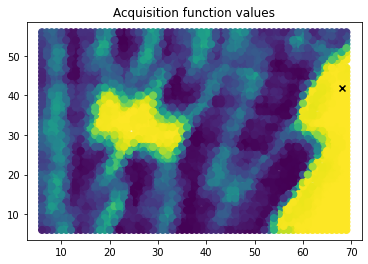

10/40
Epoch 1/200 ... Training loss: 0.8917
Epoch 10/200 ... Training loss: 0.8734
Epoch 20/200 ... Training loss: 0.8188
Epoch 30/200 ... Training loss: 0.7714
Epoch 40/200 ... Training loss: 0.7267
Epoch 50/200 ... Training loss: 0.6817
Epoch 60/200 ... Training loss: 0.6376
Epoch 70/200 ... Training loss: 0.5928
Epoch 80/200 ... Training loss: 0.5479
Epoch 90/200 ... Training loss: 0.5018
Epoch 100/200 ... Training loss: 0.4553
Epoch 110/200 ... Training loss: 0.4096
Epoch 120/200 ... Training loss: 0.3647
Epoch 130/200 ... Training loss: 0.3198
Epoch 140/200 ... Training loss: 0.2751
Epoch 150/200 ... Training loss: 0.2309
Epoch 160/200 ... Training loss: 0.1876
Epoch 170/200 ... Training loss: 0.1453
Epoch 180/200 ... Training loss: 0.1037
Epoch 190/200 ... Training loss: 0.0612
Epoch 200/200 ... Training loss: 0.0202


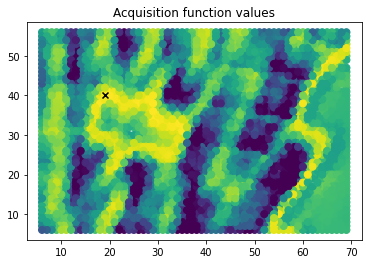

11/40
Epoch 1/200 ... Training loss: 0.8847
Epoch 10/200 ... Training loss: 0.8692
Epoch 20/200 ... Training loss: 0.8175
Epoch 30/200 ... Training loss: 0.7689
Epoch 40/200 ... Training loss: 0.7227
Epoch 50/200 ... Training loss: 0.6777
Epoch 60/200 ... Training loss: 0.6336
Epoch 70/200 ... Training loss: 0.5896
Epoch 80/200 ... Training loss: 0.5456
Epoch 90/200 ... Training loss: 0.501
Epoch 100/200 ... Training loss: 0.456
Epoch 110/200 ... Training loss: 0.4105
Epoch 120/200 ... Training loss: 0.3643
Epoch 130/200 ... Training loss: 0.3189
Epoch 140/200 ... Training loss: 0.274
Epoch 150/200 ... Training loss: 0.2294
Epoch 160/200 ... Training loss: 0.1853
Epoch 170/200 ... Training loss: 0.1421
Epoch 180/200 ... Training loss: 0.1021
Epoch 190/200 ... Training loss: 0.0587
Epoch 200/200 ... Training loss: 0.0161


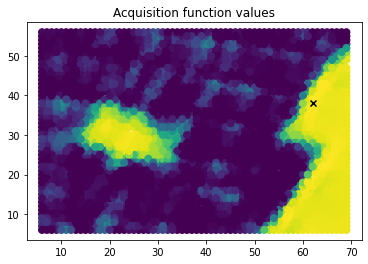

12/40
Epoch 1/200 ... Training loss: 0.8789
Epoch 10/200 ... Training loss: 0.8583
Epoch 20/200 ... Training loss: 0.8054
Epoch 30/200 ... Training loss: 0.7591
Epoch 40/200 ... Training loss: 0.7142
Epoch 50/200 ... Training loss: 0.6703
Epoch 60/200 ... Training loss: 0.6268
Epoch 70/200 ... Training loss: 0.5832
Epoch 80/200 ... Training loss: 0.5525
Epoch 90/200 ... Training loss: 0.4949
Epoch 100/200 ... Training loss: 0.4506
Epoch 110/200 ... Training loss: 0.406
Epoch 120/200 ... Training loss: 0.3608
Epoch 130/200 ... Training loss: 0.315
Epoch 140/200 ... Training loss: 0.2697
Epoch 150/200 ... Training loss: 0.225
Epoch 160/200 ... Training loss: 0.1811
Epoch 170/200 ... Training loss: 0.1362
Epoch 180/200 ... Training loss: 0.0925
Epoch 190/200 ... Training loss: 0.0494
Epoch 200/200 ... Training loss: 0.0071


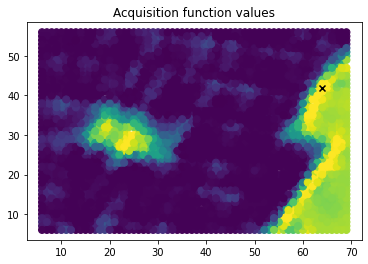

13/40
Epoch 1/200 ... Training loss: 0.8735
Epoch 10/200 ... Training loss: 0.8538
Epoch 20/200 ... Training loss: 0.8009
Epoch 30/200 ... Training loss: 0.7541
Epoch 40/200 ... Training loss: 0.7094
Epoch 50/200 ... Training loss: 0.6655
Epoch 60/200 ... Training loss: 0.622
Epoch 70/200 ... Training loss: 0.5782
Epoch 80/200 ... Training loss: 0.5336
Epoch 90/200 ... Training loss: 0.4876
Epoch 100/200 ... Training loss: 0.4411
Epoch 110/200 ... Training loss: 0.3962
Epoch 120/200 ... Training loss: 0.3516
Epoch 130/200 ... Training loss: 0.3058
Epoch 140/200 ... Training loss: 0.2605
Epoch 150/200 ... Training loss: 0.2154
Epoch 160/200 ... Training loss: 0.1711
Epoch 170/200 ... Training loss: 0.128
Epoch 180/200 ... Training loss: 0.0852
Epoch 190/200 ... Training loss: 0.0411
Epoch 200/200 ... Training loss: -0.0023


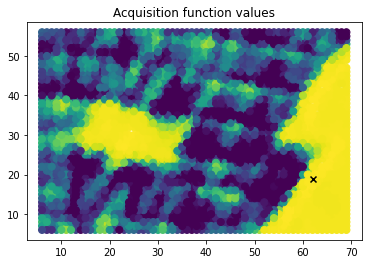

14/40
Epoch 1/200 ... Training loss: 0.8702
Epoch 10/200 ... Training loss: 0.8454
Epoch 20/200 ... Training loss: 0.7997
Epoch 30/200 ... Training loss: 0.7524
Epoch 40/200 ... Training loss: 0.707
Epoch 50/200 ... Training loss: 0.6627
Epoch 60/200 ... Training loss: 0.6189
Epoch 70/200 ... Training loss: 0.5752
Epoch 80/200 ... Training loss: 0.531
Epoch 90/200 ... Training loss: 0.4858
Epoch 100/200 ... Training loss: 0.4391
Epoch 110/200 ... Training loss: 0.3927
Epoch 120/200 ... Training loss: 0.347
Epoch 130/200 ... Training loss: 0.3011
Epoch 140/200 ... Training loss: 0.2553
Epoch 150/200 ... Training loss: 0.2098
Epoch 160/200 ... Training loss: 0.1647
Epoch 170/200 ... Training loss: 0.1201
Epoch 180/200 ... Training loss: 0.0757
Epoch 190/200 ... Training loss: 0.0319
Epoch 200/200 ... Training loss: -0.0105


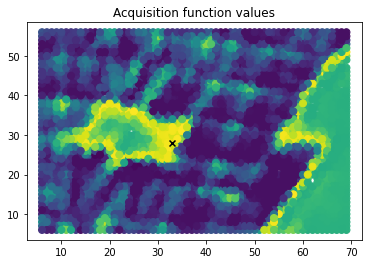

15/40
Epoch 1/200 ... Training loss: 0.8663
Epoch 10/200 ... Training loss: 0.8439
Epoch 20/200 ... Training loss: 0.7958
Epoch 30/200 ... Training loss: 0.7482
Epoch 40/200 ... Training loss: 0.7019
Epoch 50/200 ... Training loss: 0.6573
Epoch 60/200 ... Training loss: 0.6136
Epoch 70/200 ... Training loss: 0.5699
Epoch 80/200 ... Training loss: 0.526
Epoch 90/200 ... Training loss: 0.4818
Epoch 100/200 ... Training loss: 0.437
Epoch 110/200 ... Training loss: 0.3917
Epoch 120/200 ... Training loss: 0.3457
Epoch 130/200 ... Training loss: 0.2996
Epoch 140/200 ... Training loss: 0.2554
Epoch 150/200 ... Training loss: 0.2077
Epoch 160/200 ... Training loss: 0.1625
Epoch 170/200 ... Training loss: 0.1173
Epoch 180/200 ... Training loss: 0.0722
Epoch 190/200 ... Training loss: 0.0277
Epoch 200/200 ... Training loss: -0.0161


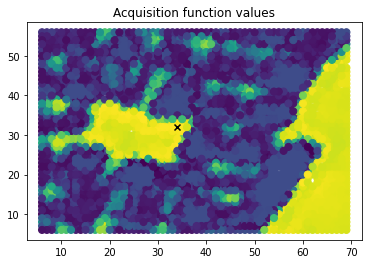

16/40
Epoch 1/200 ... Training loss: 0.8637
Epoch 10/200 ... Training loss: 0.8342
Epoch 20/200 ... Training loss: 0.7929
Epoch 30/200 ... Training loss: 0.7416
Epoch 40/200 ... Training loss: 0.6974
Epoch 50/200 ... Training loss: 0.6525
Epoch 60/200 ... Training loss: 0.6088
Epoch 70/200 ... Training loss: 0.5653
Epoch 80/200 ... Training loss: 0.521
Epoch 90/200 ... Training loss: 0.4759
Epoch 100/200 ... Training loss: 0.4303
Epoch 110/200 ... Training loss: 0.3842
Epoch 120/200 ... Training loss: 0.3391
Epoch 130/200 ... Training loss: 0.2935
Epoch 140/200 ... Training loss: 0.2477
Epoch 150/200 ... Training loss: 0.202
Epoch 160/200 ... Training loss: 0.1571
Epoch 170/200 ... Training loss: 0.1127
Epoch 180/200 ... Training loss: 0.0685
Epoch 190/200 ... Training loss: 0.0231
Epoch 200/200 ... Training loss: -0.0211


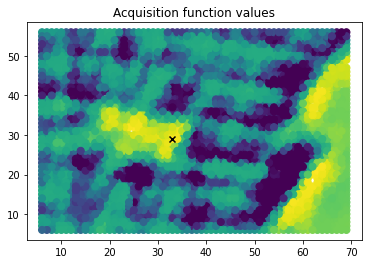

17/40
Epoch 1/200 ... Training loss: 0.8606
Epoch 10/200 ... Training loss: 0.8373
Epoch 20/200 ... Training loss: 0.7855
Epoch 30/200 ... Training loss: 0.7402
Epoch 40/200 ... Training loss: 0.6941
Epoch 50/200 ... Training loss: 0.6499
Epoch 60/200 ... Training loss: 0.6061
Epoch 70/200 ... Training loss: 0.5625
Epoch 80/200 ... Training loss: 0.5186
Epoch 90/200 ... Training loss: 0.4743
Epoch 100/200 ... Training loss: 0.4294
Epoch 110/200 ... Training loss: 0.384
Epoch 120/200 ... Training loss: 0.3378
Epoch 130/200 ... Training loss: 0.2904
Epoch 140/200 ... Training loss: 0.2443
Epoch 150/200 ... Training loss: 0.1976
Epoch 160/200 ... Training loss: 0.151
Epoch 170/200 ... Training loss: 0.1048
Epoch 180/200 ... Training loss: 0.0595
Epoch 190/200 ... Training loss: 0.015
Epoch 200/200 ... Training loss: -0.0286


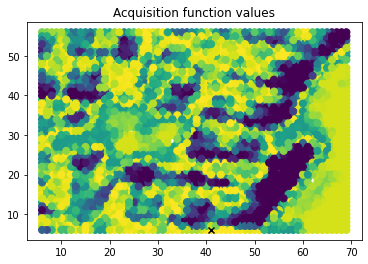

18/40
Epoch 1/200 ... Training loss: 0.8577
Epoch 10/200 ... Training loss: 0.8394
Epoch 20/200 ... Training loss: 0.7875
Epoch 30/200 ... Training loss: 0.7391
Epoch 40/200 ... Training loss: 0.6946
Epoch 50/200 ... Training loss: 0.6493
Epoch 60/200 ... Training loss: 0.6054
Epoch 70/200 ... Training loss: 0.5619
Epoch 80/200 ... Training loss: 0.5181
Epoch 90/200 ... Training loss: 0.4734
Epoch 100/200 ... Training loss: 0.4278
Epoch 110/200 ... Training loss: 0.3814
Epoch 120/200 ... Training loss: 0.3351
Epoch 130/200 ... Training loss: 0.2888
Epoch 140/200 ... Training loss: 0.243
Epoch 150/200 ... Training loss: 0.197
Epoch 160/200 ... Training loss: 0.1505
Epoch 170/200 ... Training loss: 0.1042
Epoch 180/200 ... Training loss: 0.0581
Epoch 190/200 ... Training loss: 0.0129
Epoch 200/200 ... Training loss: -0.0315


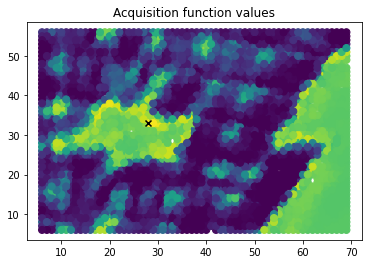

19/40
Epoch 1/200 ... Training loss: 0.855
Epoch 10/200 ... Training loss: 0.8342
Epoch 20/200 ... Training loss: 0.7832
Epoch 30/200 ... Training loss: 0.7397
Epoch 40/200 ... Training loss: 0.6915
Epoch 50/200 ... Training loss: 0.647
Epoch 60/200 ... Training loss: 0.6035
Epoch 70/200 ... Training loss: 0.5597
Epoch 80/200 ... Training loss: 0.5154
Epoch 90/200 ... Training loss: 0.4703
Epoch 100/200 ... Training loss: 0.4246
Epoch 110/200 ... Training loss: 0.3787
Epoch 120/200 ... Training loss: 0.3325
Epoch 130/200 ... Training loss: 0.2859
Epoch 140/200 ... Training loss: 0.2396
Epoch 150/200 ... Training loss: 0.193
Epoch 160/200 ... Training loss: 0.1461
Epoch 170/200 ... Training loss: 0.0999
Epoch 180/200 ... Training loss: 0.0544
Epoch 190/200 ... Training loss: 0.0097
Epoch 200/200 ... Training loss: -0.0343


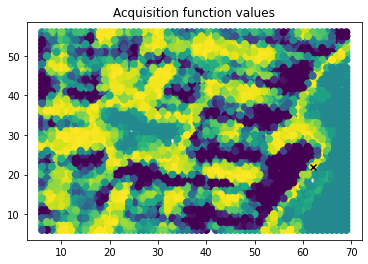

20/40
Epoch 1/200 ... Training loss: 0.8525
Epoch 10/200 ... Training loss: 0.8236
Epoch 20/200 ... Training loss: 0.7798
Epoch 30/200 ... Training loss: 0.7355
Epoch 40/200 ... Training loss: 0.6889
Epoch 50/200 ... Training loss: 0.6445
Epoch 60/200 ... Training loss: 0.6009
Epoch 70/200 ... Training loss: 0.5571
Epoch 80/200 ... Training loss: 0.5118
Epoch 90/200 ... Training loss: 0.4661
Epoch 100/200 ... Training loss: 0.4207
Epoch 110/200 ... Training loss: 0.3748
Epoch 120/200 ... Training loss: 0.3288
Epoch 130/200 ... Training loss: 0.2826
Epoch 140/200 ... Training loss: 0.2367
Epoch 150/200 ... Training loss: 0.1909
Epoch 160/200 ... Training loss: 0.1455
Epoch 170/200 ... Training loss: 0.1
Epoch 180/200 ... Training loss: 0.055
Epoch 190/200 ... Training loss: 0.0101
Epoch 200/200 ... Training loss: -0.0349


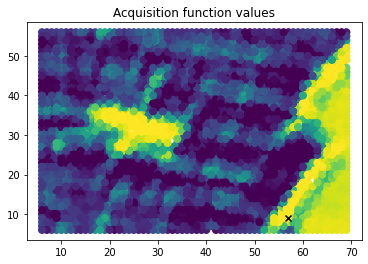

21/40
Epoch 1/200 ... Training loss: 0.85
Epoch 10/200 ... Training loss: 0.8212
Epoch 20/200 ... Training loss: 0.781
Epoch 30/200 ... Training loss: 0.7337
Epoch 40/200 ... Training loss: 0.6875
Epoch 50/200 ... Training loss: 0.6431
Epoch 60/200 ... Training loss: 0.5998
Epoch 70/200 ... Training loss: 0.5565
Epoch 80/200 ... Training loss: 0.5129
Epoch 90/200 ... Training loss: 0.4686
Epoch 100/200 ... Training loss: 0.4238
Epoch 110/200 ... Training loss: 0.3785
Epoch 120/200 ... Training loss: 0.3324
Epoch 130/200 ... Training loss: 0.2854
Epoch 140/200 ... Training loss: 0.2382
Epoch 150/200 ... Training loss: 0.1908
Epoch 160/200 ... Training loss: 0.1448
Epoch 170/200 ... Training loss: 0.099
Epoch 180/200 ... Training loss: 0.0533
Epoch 190/200 ... Training loss: 0.0073
Epoch 200/200 ... Training loss: -0.038


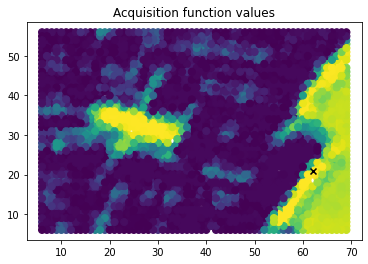

22/40
Epoch 1/200 ... Training loss: 0.8478
Epoch 10/200 ... Training loss: 0.8243
Epoch 20/200 ... Training loss: 0.7754
Epoch 30/200 ... Training loss: 0.7291
Epoch 40/200 ... Training loss: 0.6841
Epoch 50/200 ... Training loss: 0.6404
Epoch 60/200 ... Training loss: 0.597
Epoch 70/200 ... Training loss: 0.5532
Epoch 80/200 ... Training loss: 0.5086
Epoch 90/200 ... Training loss: 0.4634
Epoch 100/200 ... Training loss: 0.4176
Epoch 110/200 ... Training loss: 0.3716
Epoch 140/200 ... Training loss: 0.2328
Epoch 150/200 ... Training loss: 0.1867
Epoch 160/200 ... Training loss: 0.1408
Epoch 170/200 ... Training loss: 0.0951
Epoch 180/200 ... Training loss: 0.0498
Epoch 190/200 ... Training loss: 0.0047
Epoch 200/200 ... Training loss: -0.0403


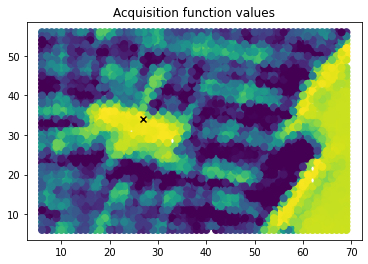

23/40
Epoch 1/200 ... Training loss: 0.847
Epoch 10/200 ... Training loss: 0.8265
Epoch 20/200 ... Training loss: 0.772
Epoch 30/200 ... Training loss: 0.7283
Epoch 40/200 ... Training loss: 0.6847
Epoch 50/200 ... Training loss: 0.6414
Epoch 60/200 ... Training loss: 0.5974
Epoch 70/200 ... Training loss: 0.5533
Epoch 80/200 ... Training loss: 0.5087
Epoch 90/200 ... Training loss: 0.4636
Epoch 100/200 ... Training loss: 0.4181
Epoch 110/200 ... Training loss: 0.3722
Epoch 120/200 ... Training loss: 0.3262
Epoch 130/200 ... Training loss: 0.2798
Epoch 140/200 ... Training loss: 0.2335
Epoch 150/200 ... Training loss: 0.1872
Epoch 160/200 ... Training loss: 0.1411
Epoch 170/200 ... Training loss: 0.0955
Epoch 180/200 ... Training loss: 0.0507
Epoch 190/200 ... Training loss: 0.0062
Epoch 200/200 ... Training loss: -0.0377


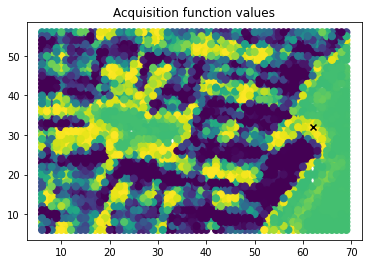

24/40
Epoch 1/200 ... Training loss: 0.8439
Epoch 10/200 ... Training loss: 0.8193
Epoch 20/200 ... Training loss: 0.7729
Epoch 30/200 ... Training loss: 0.7285
Epoch 40/200 ... Training loss: 0.6831
Epoch 50/200 ... Training loss: 0.6396
Epoch 60/200 ... Training loss: 0.5962
Epoch 70/200 ... Training loss: 0.5528
Epoch 80/200 ... Training loss: 0.5091
Epoch 90/200 ... Training loss: 0.4648
Epoch 100/200 ... Training loss: 0.4201
Epoch 110/200 ... Training loss: 0.3749
Epoch 120/200 ... Training loss: 0.3291
Epoch 130/200 ... Training loss: 0.2827
Epoch 140/200 ... Training loss: 0.2358
Epoch 150/200 ... Training loss: 0.189
Epoch 160/200 ... Training loss: 0.142
Epoch 170/200 ... Training loss: 0.0955
Epoch 180/200 ... Training loss: 0.0493
Epoch 190/200 ... Training loss: 0.0035
Epoch 200/200 ... Training loss: -0.0417


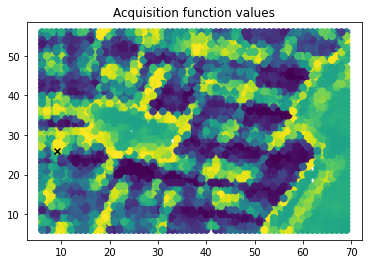

25/40
Epoch 1/200 ... Training loss: 0.8413
Epoch 10/200 ... Training loss: 0.8201
Epoch 20/200 ... Training loss: 0.7724
Epoch 30/200 ... Training loss: 0.7256
Epoch 40/200 ... Training loss: 0.6835
Epoch 50/200 ... Training loss: 0.6386
Epoch 60/200 ... Training loss: 0.5952
Epoch 70/200 ... Training loss: 0.5518
Epoch 80/200 ... Training loss: 0.5079
Epoch 90/200 ... Training loss: 0.4629
Epoch 100/200 ... Training loss: 0.4163
Epoch 110/200 ... Training loss: 0.3688
Epoch 120/200 ... Training loss: 0.3217
Epoch 130/200 ... Training loss: 0.2745
Epoch 140/200 ... Training loss: 0.228
Epoch 150/200 ... Training loss: 0.1815
Epoch 160/200 ... Training loss: 0.1353
Epoch 170/200 ... Training loss: 0.0892
Epoch 180/200 ... Training loss: 0.0436
Epoch 190/200 ... Training loss: -0.0022
Epoch 200/200 ... Training loss: -0.0476


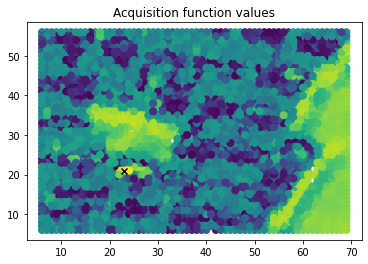

26/40
Epoch 1/200 ... Training loss: 0.841
Epoch 10/200 ... Training loss: 0.8178
Epoch 20/200 ... Training loss: 0.7706
Epoch 30/200 ... Training loss: 0.7246
Epoch 40/200 ... Training loss: 0.6812
Epoch 50/200 ... Training loss: 0.6372
Epoch 60/200 ... Training loss: 0.5932
Epoch 70/200 ... Training loss: 0.5487
Epoch 80/200 ... Training loss: 0.5033
Epoch 90/200 ... Training loss: 0.458
Epoch 100/200 ... Training loss: 0.4123
Epoch 110/200 ... Training loss: 0.3664
Epoch 120/200 ... Training loss: 0.3201
Epoch 130/200 ... Training loss: 0.2738
Epoch 140/200 ... Training loss: 0.2275
Epoch 150/200 ... Training loss: 0.1812
Epoch 160/200 ... Training loss: 0.1347
Epoch 170/200 ... Training loss: 0.0887
Epoch 180/200 ... Training loss: 0.0433
Epoch 190/200 ... Training loss: -0.0017
Epoch 200/200 ... Training loss: -0.0463


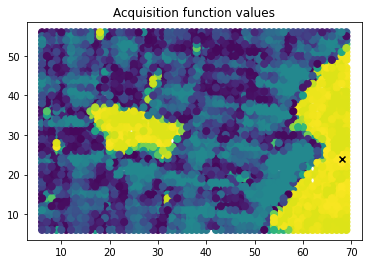

27/40
Epoch 1/200 ... Training loss: 0.8387
Epoch 10/200 ... Training loss: 0.8102
Epoch 20/200 ... Training loss: 0.7705
Epoch 30/200 ... Training loss: 0.7238
Epoch 40/200 ... Training loss: 0.6798
Epoch 50/200 ... Training loss: 0.6367
Epoch 60/200 ... Training loss: 0.5931
Epoch 70/200 ... Training loss: 0.549
Epoch 80/200 ... Training loss: 0.5046
Epoch 90/200 ... Training loss: 0.4592
Epoch 100/200 ... Training loss: 0.4134
Epoch 110/200 ... Training loss: 0.3673
Epoch 120/200 ... Training loss: 0.3208
Epoch 130/200 ... Training loss: 0.2743
Epoch 140/200 ... Training loss: 0.2274
Epoch 150/200 ... Training loss: 0.1806
Epoch 160/200 ... Training loss: 0.1341
Epoch 170/200 ... Training loss: 0.0878
Epoch 180/200 ... Training loss: 0.0417
Epoch 190/200 ... Training loss: -0.0041
Epoch 200/200 ... Training loss: -0.0498


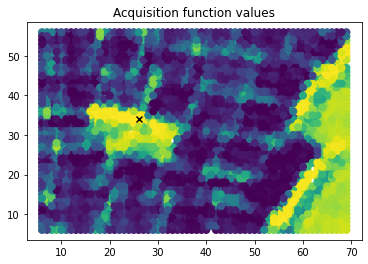

28/40
Epoch 1/200 ... Training loss: 0.8376
Epoch 10/200 ... Training loss: 0.8083
Epoch 20/200 ... Training loss: 0.7667
Epoch 30/200 ... Training loss: 0.7217
Epoch 40/200 ... Training loss: 0.6885
Epoch 50/200 ... Training loss: 0.6341
Epoch 60/200 ... Training loss: 0.5898
Epoch 70/200 ... Training loss: 0.5464
Epoch 80/200 ... Training loss: 0.5017
Epoch 90/200 ... Training loss: 0.4566
Epoch 100/200 ... Training loss: 0.4114
Epoch 110/200 ... Training loss: 0.3659
Epoch 120/200 ... Training loss: 0.3201
Epoch 130/200 ... Training loss: 0.2738
Epoch 140/200 ... Training loss: 0.2273
Epoch 150/200 ... Training loss: 0.1809
Epoch 160/200 ... Training loss: 0.1347
Epoch 170/200 ... Training loss: 0.0886
Epoch 180/200 ... Training loss: 0.0426
Epoch 190/200 ... Training loss: -0.0024
Epoch 200/200 ... Training loss: -0.0491


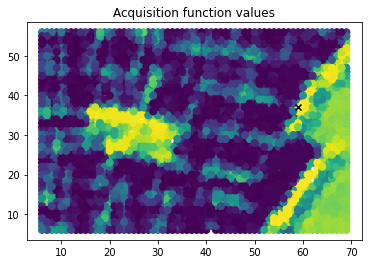

29/40
Epoch 1/200 ... Training loss: 0.8354
Epoch 10/200 ... Training loss: 0.8118
Epoch 20/200 ... Training loss: 0.7659
Epoch 30/200 ... Training loss: 0.7203
Epoch 40/200 ... Training loss: 0.6759
Epoch 50/200 ... Training loss: 0.6346
Epoch 60/200 ... Training loss: 0.5901
Epoch 70/200 ... Training loss: 0.546
Epoch 80/200 ... Training loss: 0.501
Epoch 90/200 ... Training loss: 0.4552
Epoch 100/200 ... Training loss: 0.4095
Epoch 110/200 ... Training loss: 0.3636
Epoch 120/200 ... Training loss: 0.3176
Epoch 130/200 ... Training loss: 0.2714
Epoch 140/200 ... Training loss: 0.2254
Epoch 150/200 ... Training loss: 0.1797
Epoch 160/200 ... Training loss: 0.1323
Epoch 170/200 ... Training loss: 0.0859
Epoch 180/200 ... Training loss: 0.0396
Epoch 190/200 ... Training loss: -0.0065
Epoch 200/200 ... Training loss: -0.0526


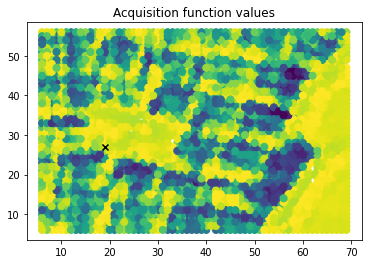

30/40
Epoch 1/200 ... Training loss: 0.8338
Epoch 10/200 ... Training loss: 0.8089
Epoch 20/200 ... Training loss: 0.7639
Epoch 30/200 ... Training loss: 0.719
Epoch 40/200 ... Training loss: 0.6762
Epoch 50/200 ... Training loss: 0.6333
Epoch 60/200 ... Training loss: 0.5896
Epoch 70/200 ... Training loss: 0.5461
Epoch 80/200 ... Training loss: 0.5006
Epoch 90/200 ... Training loss: 0.4548
Epoch 100/200 ... Training loss: 0.4086
Epoch 110/200 ... Training loss: 0.3622
Epoch 120/200 ... Training loss: 0.3158
Epoch 130/200 ... Training loss: 0.2693
Epoch 140/200 ... Training loss: 0.2228
Epoch 150/200 ... Training loss: 0.1759
Epoch 160/200 ... Training loss: 0.1293
Epoch 170/200 ... Training loss: 0.0828
Epoch 180/200 ... Training loss: 0.0365
Epoch 190/200 ... Training loss: -0.0099
Epoch 200/200 ... Training loss: -0.0563


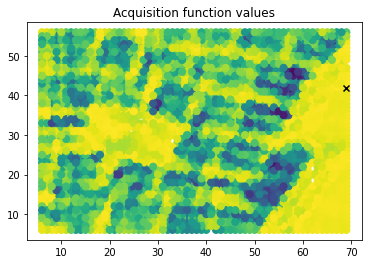

31/40
Epoch 1/200 ... Training loss: 0.8315
Epoch 10/200 ... Training loss: 0.8065
Epoch 20/200 ... Training loss: 0.7628
Epoch 30/200 ... Training loss: 0.7198
Epoch 40/200 ... Training loss: 0.6761
Epoch 50/200 ... Training loss: 0.6327
Epoch 60/200 ... Training loss: 0.5893
Epoch 70/200 ... Training loss: 0.5455
Epoch 80/200 ... Training loss: 0.5008
Epoch 90/200 ... Training loss: 0.4553
Epoch 100/200 ... Training loss: 0.4091
Epoch 110/200 ... Training loss: 0.3625
Epoch 120/200 ... Training loss: 0.316
Epoch 130/200 ... Training loss: 0.2692
Epoch 140/200 ... Training loss: 0.2223
Epoch 150/200 ... Training loss: 0.1752
Epoch 160/200 ... Training loss: 0.1282
Epoch 170/200 ... Training loss: 0.0815
Epoch 180/200 ... Training loss: 0.0348
Epoch 190/200 ... Training loss: -0.0118
Epoch 200/200 ... Training loss: -0.0586


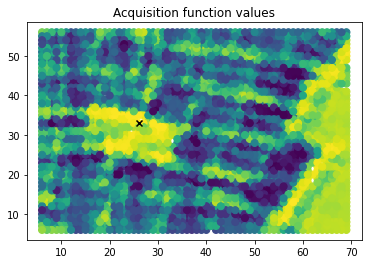

32/40
Epoch 1/200 ... Training loss: 0.83
Epoch 10/200 ... Training loss: 0.8029
Epoch 20/200 ... Training loss: 0.7588
Epoch 30/200 ... Training loss: 0.715
Epoch 40/200 ... Training loss: 0.6722
Epoch 50/200 ... Training loss: 0.629
Epoch 60/200 ... Training loss: 0.5841
Epoch 70/200 ... Training loss: 0.5374
Epoch 80/200 ... Training loss: 0.4927
Epoch 90/200 ... Training loss: 0.4549
Epoch 100/200 ... Training loss: 0.4119
Epoch 110/200 ... Training loss: 0.3656
Epoch 120/200 ... Training loss: 0.3184
Epoch 130/200 ... Training loss: 0.2707
Epoch 140/200 ... Training loss: 0.223
Epoch 150/200 ... Training loss: 0.1756
Epoch 160/200 ... Training loss: 0.1287
Epoch 170/200 ... Training loss: 0.0821
Epoch 180/200 ... Training loss: 0.0352
Epoch 190/200 ... Training loss: -0.0115
Epoch 200/200 ... Training loss: -0.0585


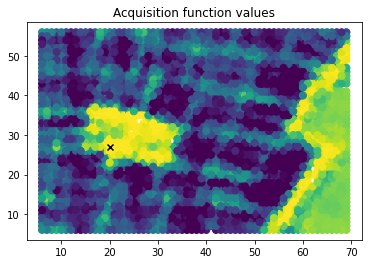

33/40
Epoch 1/200 ... Training loss: 0.8286
Epoch 10/200 ... Training loss: 0.8035
Epoch 20/200 ... Training loss: 0.7581
Epoch 30/200 ... Training loss: 0.7141
Epoch 40/200 ... Training loss: 0.6699
Epoch 50/200 ... Training loss: 0.6264
Epoch 60/200 ... Training loss: 0.5823
Epoch 70/200 ... Training loss: 0.5373
Epoch 80/200 ... Training loss: 0.4924
Epoch 90/200 ... Training loss: 0.4473
Epoch 100/200 ... Training loss: 0.4016
Epoch 110/200 ... Training loss: 0.3557
Epoch 120/200 ... Training loss: 0.3097
Epoch 130/200 ... Training loss: 0.2636
Epoch 140/200 ... Training loss: 0.2174
Epoch 150/200 ... Training loss: 0.1711
Epoch 160/200 ... Training loss: 0.1247
Epoch 170/200 ... Training loss: 0.0784
Epoch 180/200 ... Training loss: 0.032
Epoch 190/200 ... Training loss: -0.0143
Epoch 200/200 ... Training loss: -0.0618


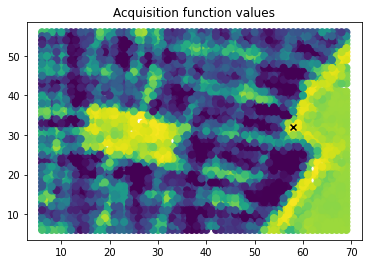

34/40
Epoch 1/200 ... Training loss: 0.8269
Epoch 10/200 ... Training loss: 0.7986
Epoch 20/200 ... Training loss: 0.7548
Epoch 30/200 ... Training loss: 0.7126
Epoch 40/200 ... Training loss: 0.6714
Epoch 50/200 ... Training loss: 0.6352
Epoch 60/200 ... Training loss: 0.5845
Epoch 70/200 ... Training loss: 0.5389
Epoch 80/200 ... Training loss: 0.5
Epoch 90/200 ... Training loss: 0.4561
Epoch 100/200 ... Training loss: 0.4112
Epoch 110/200 ... Training loss: 0.3654
Epoch 120/200 ... Training loss: 0.3189
Epoch 130/200 ... Training loss: 0.272
Epoch 140/200 ... Training loss: 0.2247
Epoch 150/200 ... Training loss: 0.1783
Epoch 160/200 ... Training loss: 0.1306
Epoch 170/200 ... Training loss: 0.0821
Epoch 180/200 ... Training loss: 0.0343
Epoch 190/200 ... Training loss: -0.0134
Epoch 200/200 ... Training loss: -0.0613


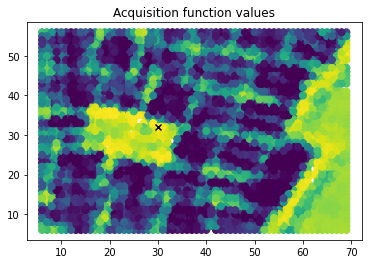

35/40
Epoch 1/200 ... Training loss: 0.8255
Epoch 10/200 ... Training loss: 0.7949
Epoch 20/200 ... Training loss: 0.7561
Epoch 30/200 ... Training loss: 0.7113
Epoch 40/200 ... Training loss: 0.6683
Epoch 50/200 ... Training loss: 0.6254
Epoch 60/200 ... Training loss: 0.5818
Epoch 70/200 ... Training loss: 0.5378
Epoch 80/200 ... Training loss: 0.4929
Epoch 90/200 ... Training loss: 0.4476
Epoch 100/200 ... Training loss: 0.402
Epoch 110/200 ... Training loss: 0.3559
Epoch 120/200 ... Training loss: 0.3095
Epoch 130/200 ... Training loss: 0.2631
Epoch 140/200 ... Training loss: 0.2159
Epoch 150/200 ... Training loss: 0.1689
Epoch 160/200 ... Training loss: 0.122
Epoch 170/200 ... Training loss: 0.0751
Epoch 180/200 ... Training loss: 0.0282
Epoch 190/200 ... Training loss: -0.0188
Epoch 200/200 ... Training loss: -0.066


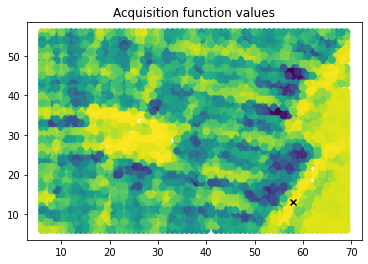

36/40
Epoch 1/200 ... Training loss: 0.8242
Epoch 10/200 ... Training loss: 0.795
Epoch 20/200 ... Training loss: 0.754
Epoch 30/200 ... Training loss: 0.7105
Epoch 40/200 ... Training loss: 0.667
Epoch 50/200 ... Training loss: 0.6236
Epoch 60/200 ... Training loss: 0.5805
Epoch 70/200 ... Training loss: 0.5356
Epoch 80/200 ... Training loss: 0.4908
Epoch 90/200 ... Training loss: 0.4457
Epoch 100/200 ... Training loss: 0.4001
Epoch 110/200 ... Training loss: 0.3543
Epoch 120/200 ... Training loss: 0.3082
Epoch 130/200 ... Training loss: 0.2617
Epoch 140/200 ... Training loss: 0.2151
Epoch 150/200 ... Training loss: 0.1682
Epoch 160/200 ... Training loss: 0.1208
Epoch 170/200 ... Training loss: 0.0735
Epoch 180/200 ... Training loss: 0.0262
Epoch 190/200 ... Training loss: -0.0212
Epoch 200/200 ... Training loss: -0.0686


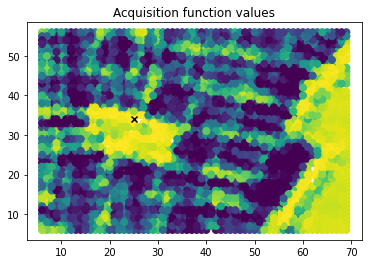

37/40
Epoch 1/200 ... Training loss: 0.8231
Epoch 10/200 ... Training loss: 0.7921
Epoch 20/200 ... Training loss: 0.7501
Epoch 30/200 ... Training loss: 0.7103
Epoch 40/200 ... Training loss: 0.6671
Epoch 50/200 ... Training loss: 0.6238
Epoch 60/200 ... Training loss: 0.5802
Epoch 70/200 ... Training loss: 0.536
Epoch 80/200 ... Training loss: 0.4909
Epoch 90/200 ... Training loss: 0.4452
Epoch 100/200 ... Training loss: 0.3994
Epoch 110/200 ... Training loss: 0.3534
Epoch 120/200 ... Training loss: 0.3072
Epoch 130/200 ... Training loss: 0.2605
Epoch 140/200 ... Training loss: 0.2137
Epoch 150/200 ... Training loss: 0.1667
Epoch 160/200 ... Training loss: 0.1198
Epoch 170/200 ... Training loss: 0.0728
Epoch 180/200 ... Training loss: 0.0256
Epoch 190/200 ... Training loss: -0.0217
Epoch 200/200 ... Training loss: -0.0692


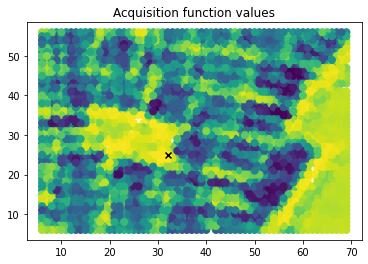

38/40
Epoch 1/200 ... Training loss: 0.8224
Epoch 10/200 ... Training loss: 0.7956
Epoch 20/200 ... Training loss: 0.7494
Epoch 30/200 ... Training loss: 0.7077
Epoch 40/200 ... Training loss: 0.6648
Epoch 50/200 ... Training loss: 0.6216
Epoch 60/200 ... Training loss: 0.5781
Epoch 70/200 ... Training loss: 0.5337
Epoch 80/200 ... Training loss: 0.4886
Epoch 90/200 ... Training loss: 0.4431
Epoch 100/200 ... Training loss: 0.3975
Epoch 110/200 ... Training loss: 0.3513
Epoch 120/200 ... Training loss: 0.3049
Epoch 130/200 ... Training loss: 0.2581
Epoch 140/200 ... Training loss: 0.2113
Epoch 150/200 ... Training loss: 0.1644
Epoch 160/200 ... Training loss: 0.1175
Epoch 170/200 ... Training loss: 0.0704
Epoch 180/200 ... Training loss: 0.0232
Epoch 190/200 ... Training loss: -0.0242
Epoch 200/200 ... Training loss: -0.0718


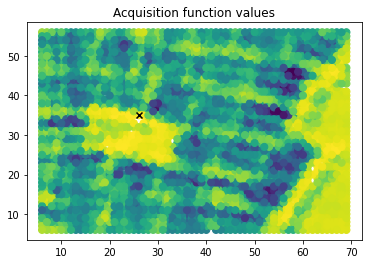

39/40
Epoch 1/200 ... Training loss: 0.8215
Epoch 10/200 ... Training loss: 0.7933
Epoch 20/200 ... Training loss: 0.747
Epoch 30/200 ... Training loss: 0.7089
Epoch 40/200 ... Training loss: 0.6641
Epoch 50/200 ... Training loss: 0.6209
Epoch 60/200 ... Training loss: 0.5764
Epoch 70/200 ... Training loss: 0.5328
Epoch 80/200 ... Training loss: 0.4868
Epoch 90/200 ... Training loss: 0.4411
Epoch 100/200 ... Training loss: 0.3957
Epoch 110/200 ... Training loss: 0.3503
Epoch 120/200 ... Training loss: 0.3041
Epoch 130/200 ... Training loss: 0.2577
Epoch 140/200 ... Training loss: 0.2113
Epoch 150/200 ... Training loss: 0.166
Epoch 160/200 ... Training loss: 0.1177
Epoch 170/200 ... Training loss: 0.0703
Epoch 180/200 ... Training loss: 0.0229
Epoch 190/200 ... Training loss: -0.0246
Epoch 200/200 ... Training loss: -0.0722


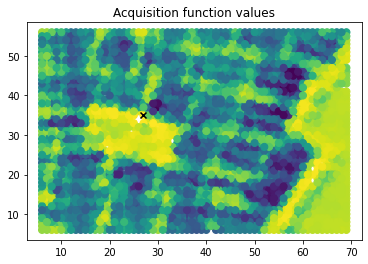

40/40
Epoch 1/200 ... Training loss: 0.8201
Epoch 10/200 ... Training loss: 0.7883
Epoch 20/200 ... Training loss: 0.7461
Epoch 30/200 ... Training loss: 0.7057
Epoch 40/200 ... Training loss: 0.6628
Epoch 50/200 ... Training loss: 0.6205
Epoch 60/200 ... Training loss: 0.5779
Epoch 70/200 ... Training loss: 0.5347
Epoch 80/200 ... Training loss: 0.4907
Epoch 90/200 ... Training loss: 0.4456
Epoch 100/200 ... Training loss: 0.3996
Epoch 110/200 ... Training loss: 0.3529
Epoch 120/200 ... Training loss: 0.306
Epoch 130/200 ... Training loss: 0.2589
Epoch 140/200 ... Training loss: 0.2117
Epoch 150/200 ... Training loss: 0.1645
Epoch 160/200 ... Training loss: 0.1171
Epoch 170/200 ... Training loss: 0.0697
Epoch 180/200 ... Training loss: 0.0222
Epoch 190/200 ... Training loss: -0.0257
Epoch 200/200 ... Training loss: -0.0737


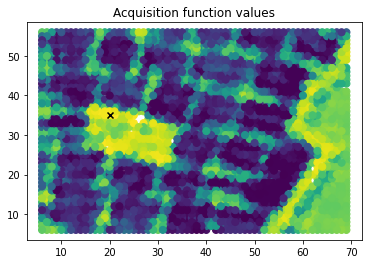

In [40]:
def plot_result(indices, obj):
    plt.scatter(indices[:, 1], indices[:, 0], s=50, c=obj)
    next_point = indices_test[obj.argmax()]
    plt.scatter(next_point[1], next_point[0], marker='x', c='k')
    plt.title("Acquisition function values")
    plt.show()


data_dim = X_train.shape[-1]

exploration_steps = 40

for e in range(exploration_steps):
    print("{}/{}".format(e+1, exploration_steps))
    # update GP posterior
    dklgp2 = aoi.models.dklGPR(data_dim, embedim=2, precision="double")
    dklgp2.fit(X_train, y_train, training_cycles=200)
    # Thompson sampling
    obj, next_point_idx = dklgp2.thompson(X_test)
    # Select next point to "measure"
    next_point = indices_test[next_point_idx]
    # Do "measurement"
    measured_point = y_test[next_point_idx]
    # Plot current result
    plot_result(indices_test, obj)
    # Append to the arrays of measured points
    X_train = np.append(X_train, X_test[next_point_idx][None], 0)
    X_test = np.delete(X_test, next_point_idx, 0)
    y_train = np.append(y_train, measured_point)
    y_test = np.delete(y_test, next_point_idx)
    indices_train = np.append(indices_train, next_point[None], 0)
    indices_test = np.delete(indices_test, next_point_idx, 0)

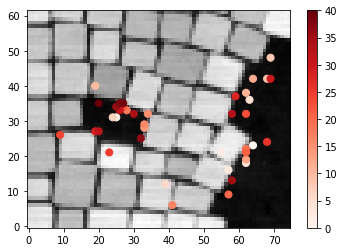

In [41]:
plt.imshow(img, origin="lower", cmap='gray')
plt.scatter(indices_train[2:, 1], indices_train[2:, 0], c=np.arange(len(indices_train[2:])), s=50, cmap="Reds")
plt.colorbar()

Overlay with a 'ground truth':

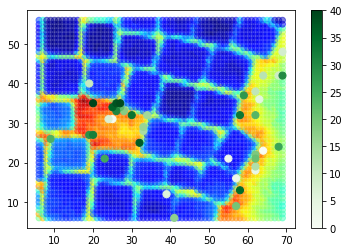

In [44]:
plt.scatter(indices_all[:, 1], indices_all[:, 0], c=peaks_all, cmap='jet', alpha=0.5)
plt.scatter(indices_train[2:, 1], indices_train[2:, 0], c=np.arange(len(indices_train[2:])), s=50, cmap="Greens")
plt.colorbar()

Looks like it did a pretty good job identifying the regions where a physical behavior of intetest is maximized. We note that in addition to the built-in Thompson sampler used here, one can utilize different types of [acquisition functions](https://www.cs.ox.ac.uk/people/nando.defreitas/publications/BayesOptLoop.pdf) for selecting the next measurement points.